In [1]:
import pandas_datareader as pdr
key="280d77d17655e235efabfe38b4945d1363b0386a"

In [2]:
df = pdr.get_data_tiingo('AAPL',api_key=key)

In [3]:
import pandas as pd

In [4]:
df.to_csv('apple.csv')

In [5]:
df.head()

close    high  ...  divCash  splitFactor
symbol date                                      ...                      
AAPL   2016-06-30 00:00:00+00:00  95.60  95.770  ...      0.0          1.0
       2016-07-01 00:00:00+00:00  95.89  96.465  ...      0.0          1.0
       2016-07-05 00:00:00+00:00  94.99  95.400  ...      0.0          1.0
       2016-07-06 00:00:00+00:00  95.53  95.660  ...      0.0          1.0
       2016-07-07 00:00:00+00:00  95.94  96.500  ...      0.0          1.0

[5 rows x 12 columns]

In [6]:
df.tail()

close     high  ...  divCash  splitFactor
symbol date                                        ...                      
AAPL   2021-06-22 00:00:00+00:00  133.98  134.080  ...      0.0          1.0
       2021-06-23 00:00:00+00:00  133.70  134.320  ...      0.0          1.0
       2021-06-24 00:00:00+00:00  133.41  134.640  ...      0.0          1.0
       2021-06-25 00:00:00+00:00  133.11  133.890  ...      0.0          1.0
       2021-06-28 00:00:00+00:00  134.78  135.245  ...      0.0          1.0

[5 rows x 12 columns]

In [54]:
df1=df.reset_index()['close']

In [55]:
df1

0        95.60
1        95.89
2        94.99
3        95.53
4        95.94
         ...  
1252    133.98
1253    133.70
1254    133.41
1255    133.11
1256    134.78
Name: close, Length: 1257, dtype: float64

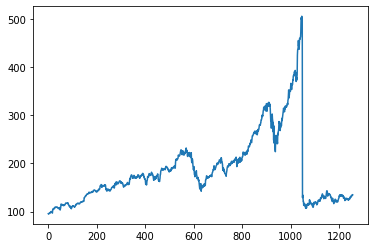

In [56]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [57]:
import numpy as np

In [58]:
df1

0        95.60
1        95.89
2        94.99
3        95.53
4        95.94
         ...  
1252    133.98
1253    133.70
1254    133.41
1255    133.11
1256    134.78
Name: close, Length: 1257, dtype: float64

In [59]:
df1.shape

(1257,)

In [60]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [61]:
df1.shape

(1257, 1)

In [62]:
print(df1)

[[0.00148382]
 [0.00218925]
 [0.        ]
 ...
 [0.09345658]
 [0.09272683]
 [0.0967891 ]]


In [63]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [64]:
training_size,test_size

(817, 440)

In [65]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [66]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [70]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [71]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [72]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [73]:
X_train.shape

(716, 100, 1)

In [20]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 304ms/step - loss: 0.0125 - val_loss: 0.0375
Epoch 2/100
12/12 [==============================] - 2s 188ms/step - loss: 0.0024 - val_loss: 0.0258
Epoch 3/100
12/12 [==============================] - 2s 188ms/step - loss: 0.0013 - val_loss: 0.0253
Epoch 4/100
12/12 [==============================] - 2s 184ms/step - loss: 7.9970e-04 - val_loss: 0.0215
Epoch 5/100
12/12 [==============================] - 2s 187ms/step - loss: 5.7993e-04 - val_loss: 0.0204
Epoch 6/100
12/12 [==============================] - 2s 184ms/step - loss: 4.7011e-04 - val_loss: 0.0212
Epoch 7/100
12/12 [==============================] - 2s 190ms/step - loss: 4.2284e-04 - val_loss: 0.0199
Epoch 8/100
12/12 [==============================] - 2s 190ms/step - loss: 4.0981e-04 - val_loss: 0.0196
Epoch 9/100
12/12 [==============================] - 2s 190ms/step - loss: 4.0535e-04 - val_loss: 0.0190
Epoch 10/100
12/12 [==============================] - 2s 193ms/step

In [24]:
import tensorflow as tf

In [25]:
tf.__version__

'2.5.0'

In [26]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [32]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

175.03476086230037

In [33]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

223.65485730086928

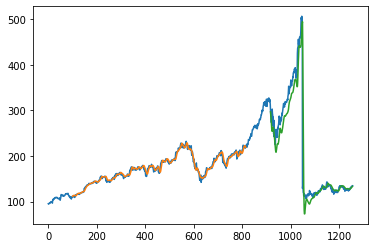

In [34]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
#Predicting for the next 30 days 

In [75]:
len(test_data)

440

In [76]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape


(1, 100)

In [77]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [78]:
len(temp_input)

100

In [79]:
temp_input

[0.10313792264655797,
 0.10160544879591338,
 0.10197032352225738,
 0.0997810751641936,
 0.09827292629530526,
 0.09764047676964244,
 0.09822427633179276,
 0.09292143030892724,
 0.08720505959620534,
 0.08445633665774754,
 0.08484553636584774,
 0.07543176842617366,
 0.07509121868158597,
 0.07385064461201651,
 0.06324495256628554,
 0.06390172707370473,
 0.07978594016054491,
 0.0732911700316225,
 0.06584772561420582,
 0.06115300413524688,
 0.06429092678180492,
 0.05198248601313549,
 0.06347603989297007,
 0.060788129408902936,
 0.06560447579664314,
 0.06334225249331066,
 0.07054244709316465,
 0.07438579421065433,
 0.07241547068839699,
 0.062126003405497454,
 0.06081245439065919,
 0.06908294818778887,
 0.06701532473850647,
 0.06105570420822187,
 0.06227195329603502,
 0.06378010216492336,
 0.06421795183653611,
 0.060593529554852865,
 0.0660666504500122,
 0.0681342738992946,
 0.07518851860861109,
 0.07594259304305523,
 0.08005351495986379,
 0.08603746047190469,
 0.09244709316468014,
 0.08817805

In [39]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.09528329]
101
1 day input [0.10160545 0.10197032 0.09978108 0.09827293 0.09764048 0.09822428
 0.09292143 0.08720506 0.08445634 0.08484554 0.07543177 0.07509122
 0.07385064 0.06324495 0.06390173 0.07978594 0.07329117 0.06584773
 0.061153   0.06429093 0.05198249 0.06347604 0.06078813 0.06560448
 0.06334225 0.07054245 0.07438579 0.07241547 0.062126   0.06081245
 0.06908295 0.06701532 0.0610557  0.06227195 0.0637801  0.06421795
 0.06059353 0.06606665 0.06813427 0.07518852 0.07594259 0.08005351
 0.08603746 0.09244709 0.08817806 0.09593773 0.09009973 0.096108
 0.09528095 0.09693505 0.09272683 0.0936755  0.08988081 0.09567015
 0.09664315 0.09584043 0.0938701  0.09362685 0.08871321 0.09134031
 0.07993189 0.08054001 0.08452931 0.08567259 0.07749939 0.07521284
 0.0675748  0.0729263  0.07895889 0.07608854 0.0726344  0.0722452
 0.07861834 0.07404524 0.07810752 0.07762102 0.07749939 0.07368037
 0.0720506  0.07124787 0.07314522 0.06944782 0.07516419 0.07518852
 0.07723182 0.07818049 0.07569934 0.

In [40]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [41]:
import matplotlib.pyplot as plt

In [42]:
len(df1)

1257

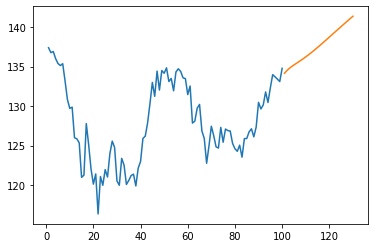

In [44]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

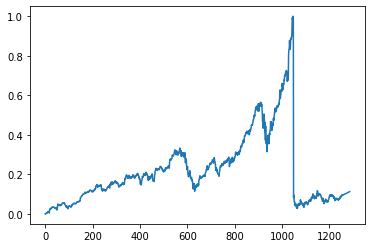

In [82]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3)

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

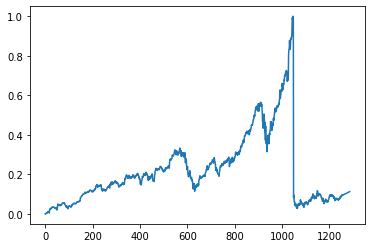

In [46]:
plt.plot(df3)